# CAB420, DCNNs, Additional Example 5: Over and Under Fitting, Layer Order and Performance Impact

Dr Simon Denman (s.denman@qut.edu.au)

## Overview

There are two big problems with deep neural networks:
* they take a long time to train
* they are easy to overfit

This example will look at a couple of things to improve that, but also at what can happen when you try to reduce things too much.

## Too Long; Didn't Read:

The main take home messages from this example are:
* It's easy to overfit with neural nets, and having limited data only makes this problem worse
* To avoid overfitting, we can reduce model complexity like we do elsewhere, but we need to be careful not to reduce it too much. If we make our network too simple, we can make it unable to learn anything. We need a certain amount of complexity to extract unseful information. If we go too far, we can end up underfitting.
* Aside from reducing complexity, we have three other tools for avoiding overfitting: weight regularisation, dropout and BatchNorm.
  * **Weight Regularisation** functions a lot like regularised regression. We add a penalty term for having large weights. This is done for much the same reason as we do in regression (ridge and lasso), very big weights can lead to a large change in the result for a small change in the input. Different toolkits will do regularisation differently, and tensorflow/keras allows you to control the regularisation for each layer. This is very powerful, but very fiddly too.
  * **Dropout** will randomly disconnect a portion of neurons each pass through the network (during training). This has be effect of meaning that for a given batch during training, only a portion of the network is updated; the deactivated neurons are ignored.
    * Dropout works really well before or after fully connected layers, but is less good for convoluational layers. With convolutional layers, because dropout removes random neurons it can remove part of a convolutional filter - but usually not all. So we end up learning partial filters, which doesn't make much sense. Hence we have spatial dropout, which will drop a percentage of whole filters. This way we still remove some of the neurons, but do so in a way that keeps filters whole. Moral of the story: if the dropout is going directly after a convolutional layer, use spatial dropout. If you can't, keep the dropout rate small.
  * **Batch Normalisation** (BatchNorm) essentially provides model checkpoints within the network. It normalises activations to a known distribution, such that subsequent layers know what to expect in terms of what range the input data will be in. This has the effect of improving the learning rate, and adding a small amount of regularisation to help avoid overfitting.
* Layer order is important, but there is a lot of debate about this still within the research community. Generally, a good order is Dropout (if being used) -> BatchNorm -> Activation (i.e. ReLu); but for different tasks this may not work best, but it's probably a good starting point.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import datetime
import numpy

import keras
from keras import layers
from keras import activations

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

E0000 00:00:1738040856.433692  562617 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738040856.437607  562617 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Setup

We're goingto use a portion of CIFAR here. CIFAR is another small image dataset. This time the images are colour, 32x32 pixles, and of 10 classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. It's a simlar size to MNIST in terms of the number of images, but more challenging with the "real world" images. We'll use only part of the dataset (1/5th) to make things faster to train, and quicker to overfit.

In general, using only 20% of the data is not recommended for optimal performance, and is only done here for demonstration purposes.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train[0:8000,:,:,:]
y_train = y_train[0:8000]
x_test = x_test[0:2000,:,:,:]
y_test = y_test[0:2000:]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


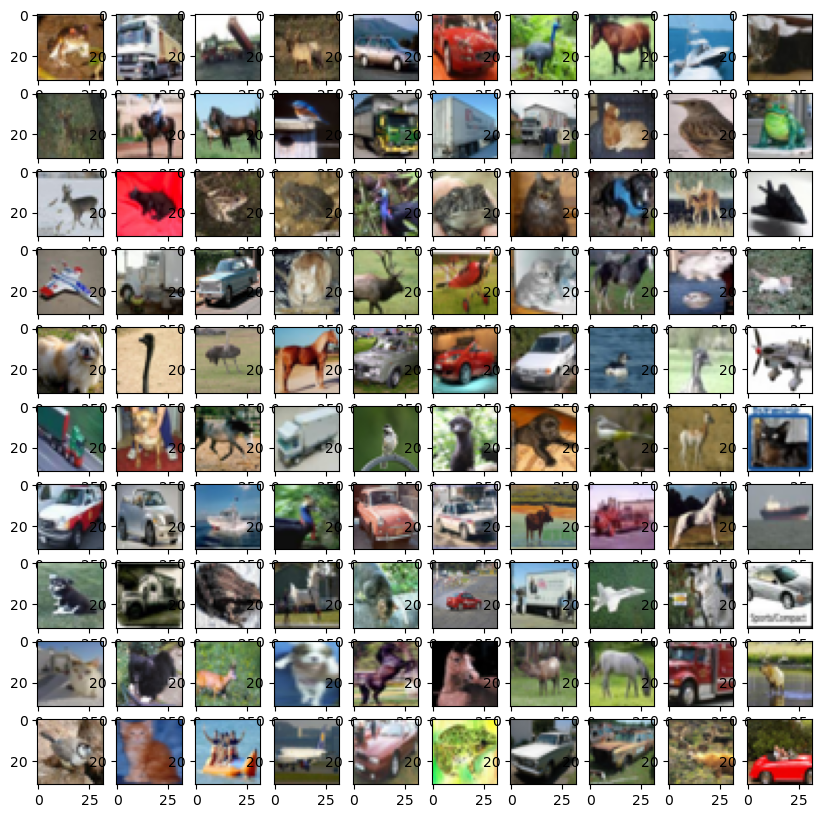

In [3]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:,:,:])

# A Simple Network
This is our base network structure that we'll play with. We have:
* An input, 32x32x3 (3 channels becuase it's a colour image)
* A pair of convolution layers, 8 filters each, 3x3 kernels
* A max pooling (2x2)
* Another pair of convolutions, 16 3x3 filters this time
* Another max pooling (2x2)
* A third pair of convolutions (32 filters, 3x3)
* A dense layer, size 64
* A fully connected layer, size 10, which is out output

All other activations are relu's, and come after each convolution.
We'll use this same base architecture throughout this example, though we'll add in extra layers in different places to look at the results.

In [4]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')
    
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
    
    pred = model.predict(x_test);
    indexes = keras.ops.argmax(pred, axis=1)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

I0000 00:00:1738040879.311302  562617 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1880 MB memory:  -> device: 0, name: NVIDIA A16-4Q, pci bus id: 0000:02:0b.0, compute capability: 8.6


I0000 00:00:1738040881.050996  562659 cuda_dnn.cc:529] Loaded cuDNN version 90300


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   


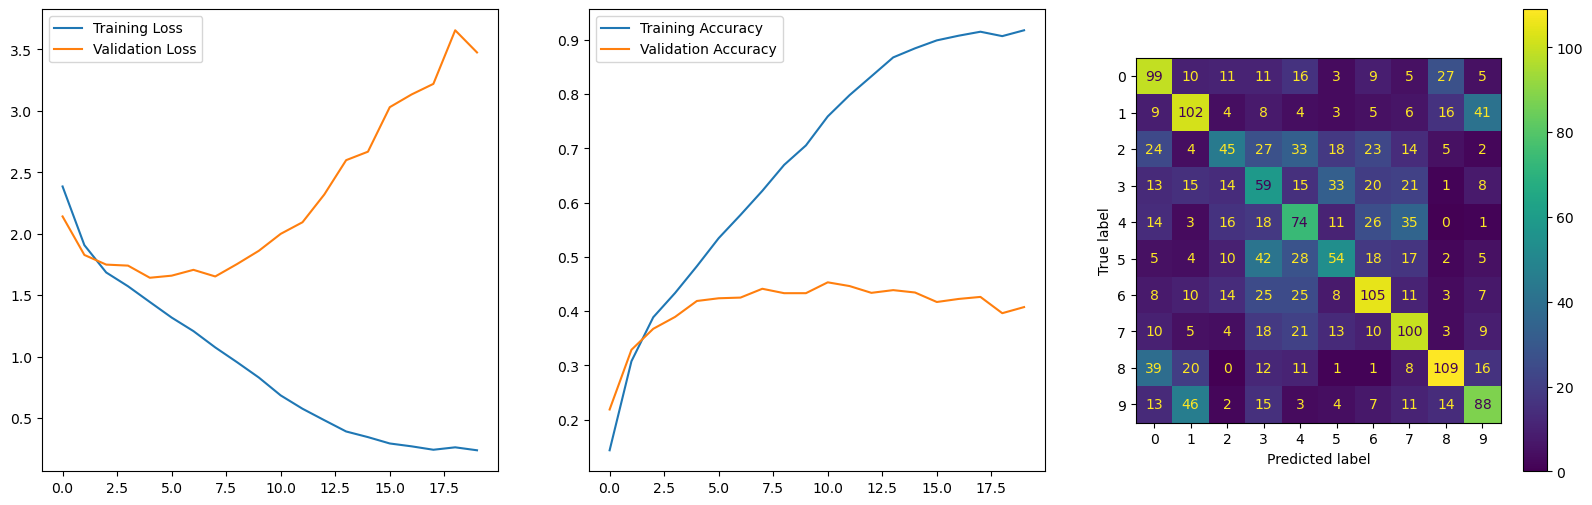

In [5]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

We can see, our network is not great, and overfits quite easily. If we keep training, our training accuracy will continue to improve up to a point, but our validation accuracy will stay stuck, and possibly even drop. We can see in the plots that our validation loss has started going the wrong way, but the validation accuracy is still (for now) constant.

For those wondering how the validation loss can go backwards while the accuracy is constant, consider what our loss is measuring. Let's say for a given ground truth sample, our target value is $[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$, i.e. the sample belongs to class 3. If the network produces an output of $[0, 0.5, 0.4, 0.1, 0, 0, 0, 0, 0, 0]$ for this sample, then the sample will be classified as class 2, yet there is still a value of $0.4$ associated with the correct class, so while the network is not correct, it is not totally wrong and the loss value for this sample will reflect that the network was somewhere near the mark. On the other hand, if the network produces an output of $[0, 0.9, 0, 0.1, 0, 0, 0, 0, 0, 0]$, then the classification result will still be class 2, yet there is now a $0$ against the true class, so the loss from categorical cross entropy will be much bigger.  

## Over and Under-fitting

We normally talk about "over-fiting" with neural nets (and we can see it above), the reason being:
* They have lots of parameters (I mean, LOTS of parameters)
* We often have limited data

However we can also under-fit. If our network is too simple, things won't train either. For example:

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


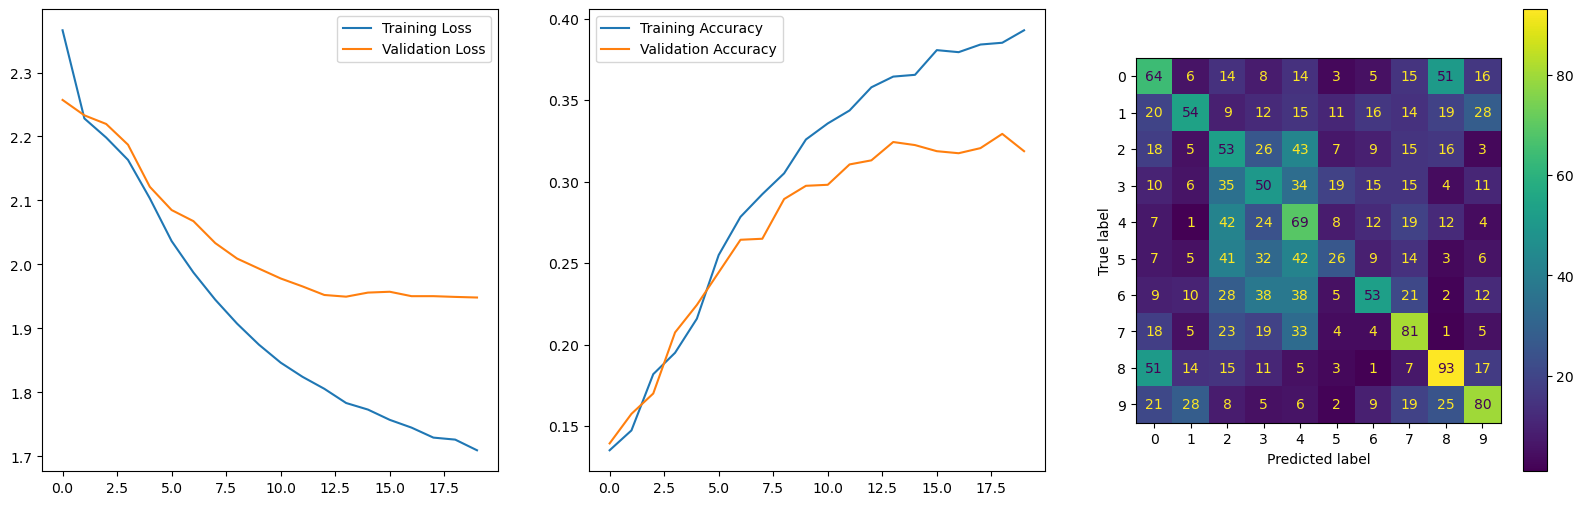

In [6]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=2, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

In this example, we've reduced the capacity of the model. We've dramatically reduced the number of filters (to quite an extreme degree), so essentialy our model can't learn as much. The end result is that the model struggles to learn.

## Weight Regularisation

We can apply regularisation to model weights, in much the same way as we do in regression. Within keras/tensorflow, we specify which layers we want to regularise, if we want to apply regularisation to the weights (kernel), bias, or activation (or any combination there of). We can also specify the type of regularisation (l1, l2, or both, or our own custom regulariser). We can't directly control the strength of the regularisation.

Let's keep it simple for now and apply an L1 regulariser to everything.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


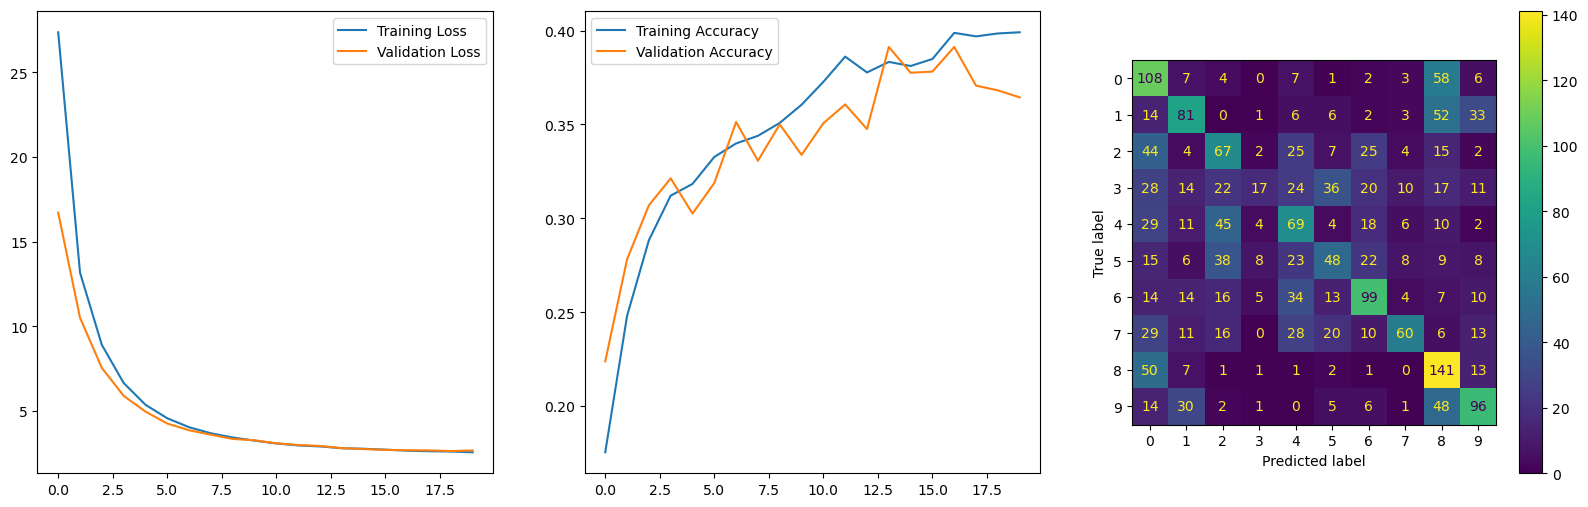

In [7]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer='l1')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

That certainly seems to have curbed our overfitting, possibly even to the extent that it's limiting learning. 

Let's try L2.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


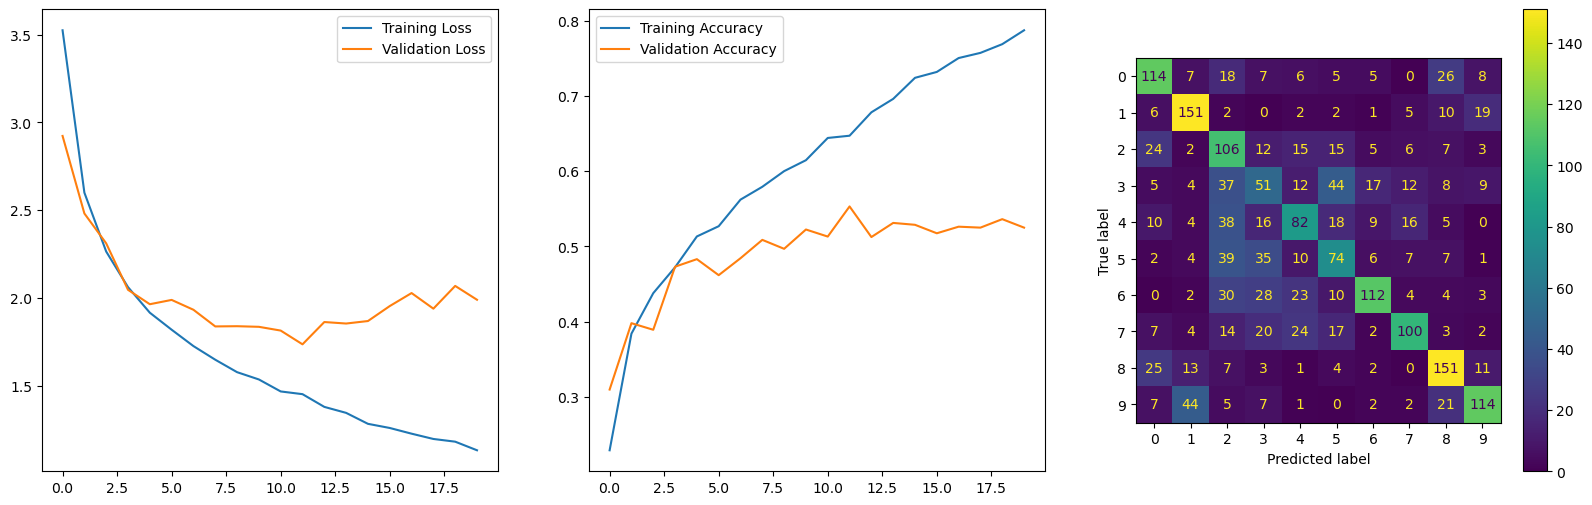

In [8]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer='l2')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

This is far less dramatic. While it does look a little better than what we started with, it's still overfitting pretty fast.

Let's see if we can improve our L1 method by being a bit more selective. Rather than applying regularisation to everything, we'll just do it to two of our convolution layers, and our first dense layer.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


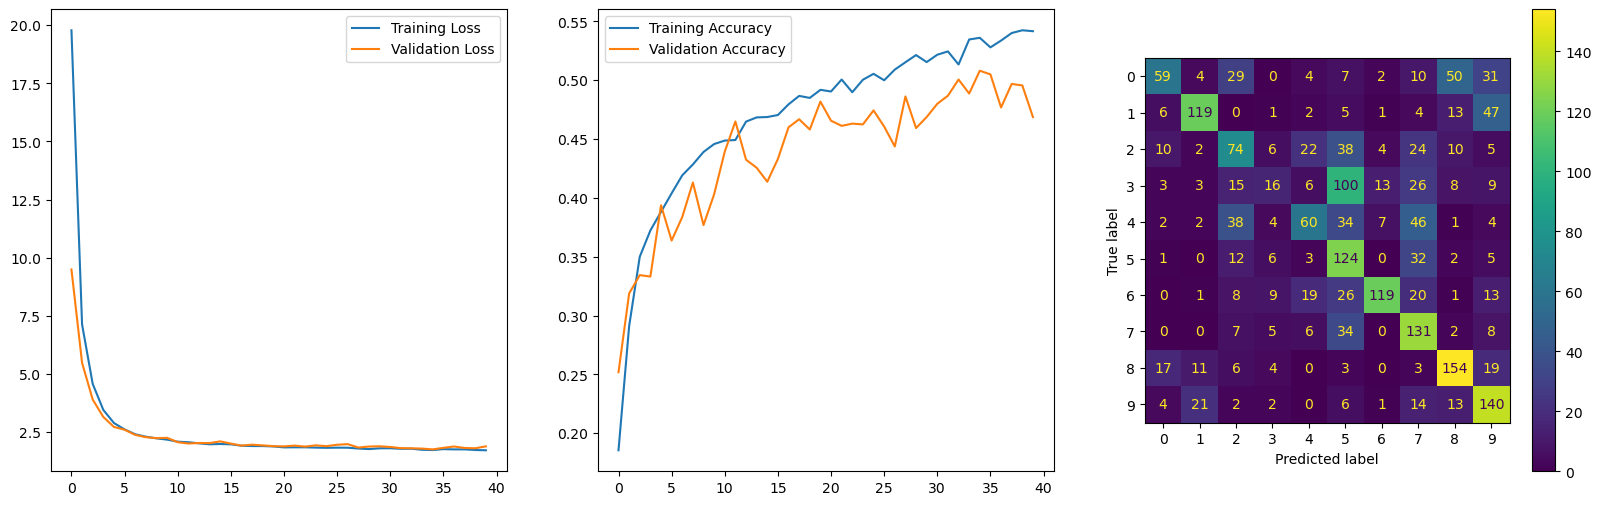

In [9]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l1')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer='l1')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=40,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

The end result is a bit more promising, and it looks as though we could aford to train for longer and may still see some improvement.

Weight regularisation is a good tool to help control overfitting, and using L1 regularisation also has interesting implications elsewhere (we can use it to learn sparse internal representations, which can be good as inputs into other processes), but it can be fiddly to implement given the layer-by-layer approach used here.

# Dropout

Dropout layers are layers that disconnect a random portion of the neurons each batch. What this means is that at any given point in time, we only train on a portion of the network. This helps prevent overfitting as the entire network never sees the same data at the same time, but it does (typically) slow training. We typically dont add dropout after every layer (but you can if you want). In our case we'll add one after each pair of convolutions.

The one parameter that we have for dropout is the number of neurons that are disconnected. This is bounded [0..1), with 0 being nothing disconnected, and up near 1 being all of the connections are dropped. If this is set too high, you'll get very slow training. If it's set too low, then it wont do it's job and the data may still overfit. We'll have a look at two dropout values:
* 0.2
* 0.8

E0000 00:00:1738040953.788873  562617 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/simple_cifar_cnn_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


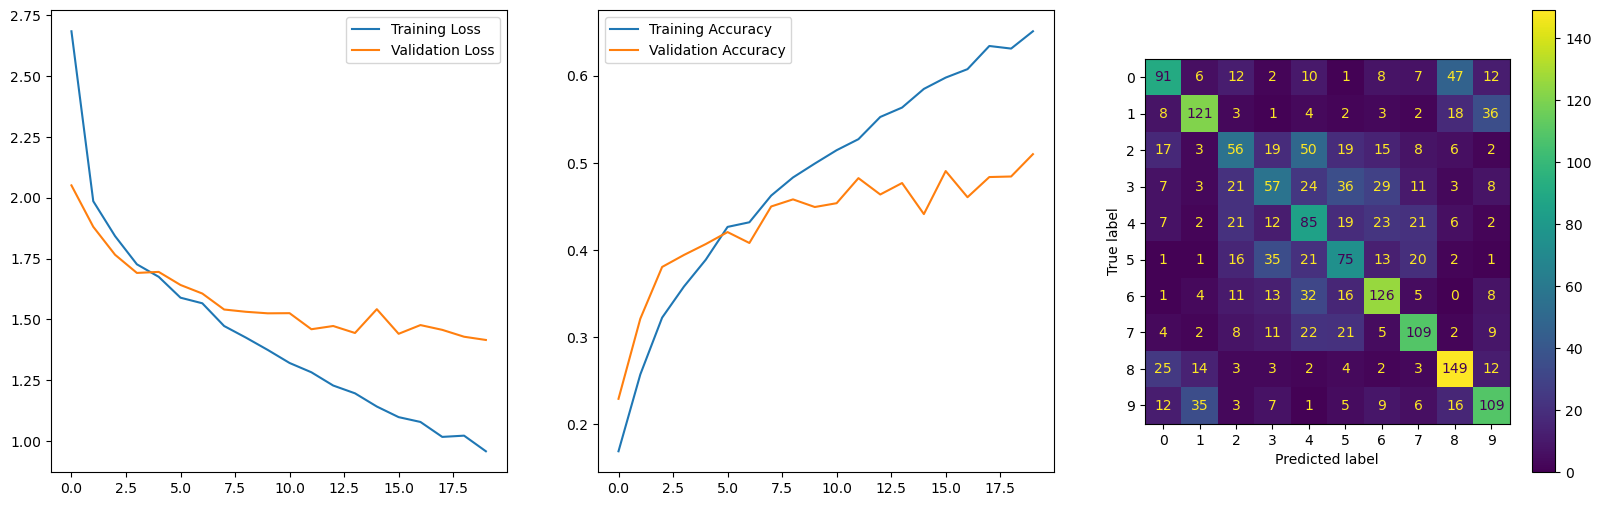

In [10]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


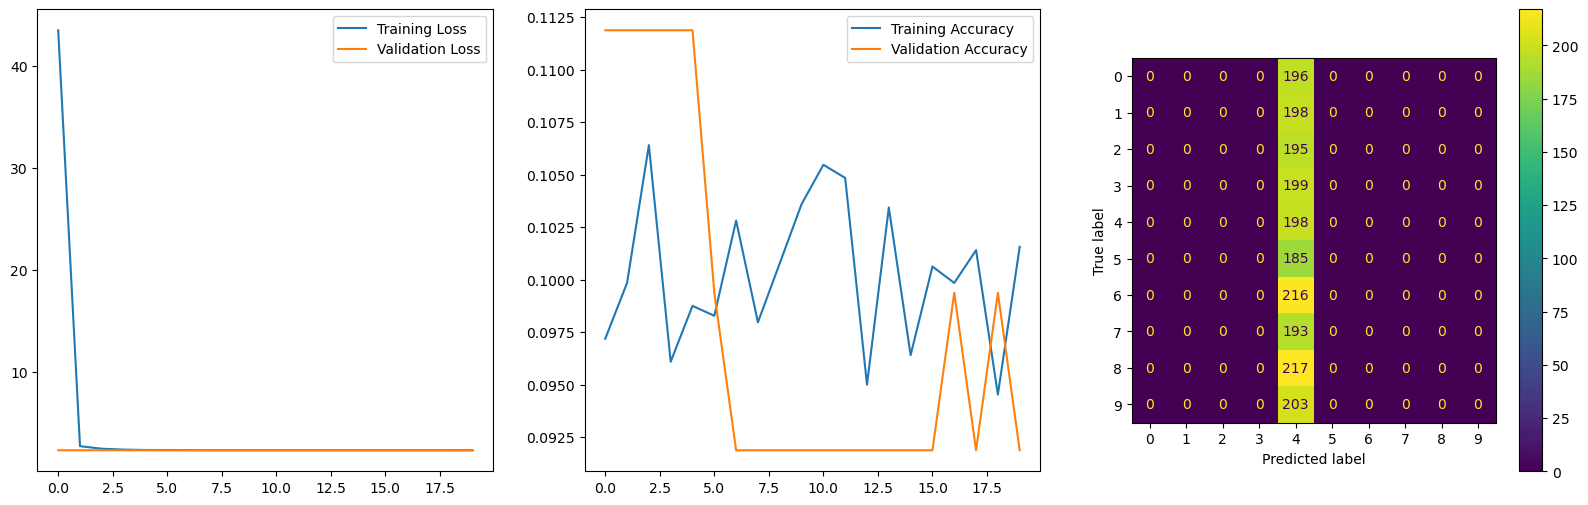

In [11]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Dropout(0.8)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Dropout(0.8)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Dropout(0.8)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.8)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

We see we get a nice grain from the Dropout at 0.2, and our network no longer overfits. With Dropout of 0.8, our network now fails to fit, basically we never have enough of the network "engaged" to learn enough. 

This is partly also caused by the way that Dropout works on convolutional layers. Dropout, in it's simplest form, disconnects random neurons. If we consider the output of a convolutional layer, it's a collection of filters, and each filter is (essentially) a set of neurons. What dropout does is randomly disconnect part of the filter - so the filters become very hard to learn with high drop out rates as most of the filter is disconneted. 

There are alternate dropout formulations that work better with convolution layers which disconnect a portion of the filters, this way any filters that are active have the whole filter still in the network, but there's just fewer of them. Let's play with that now.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


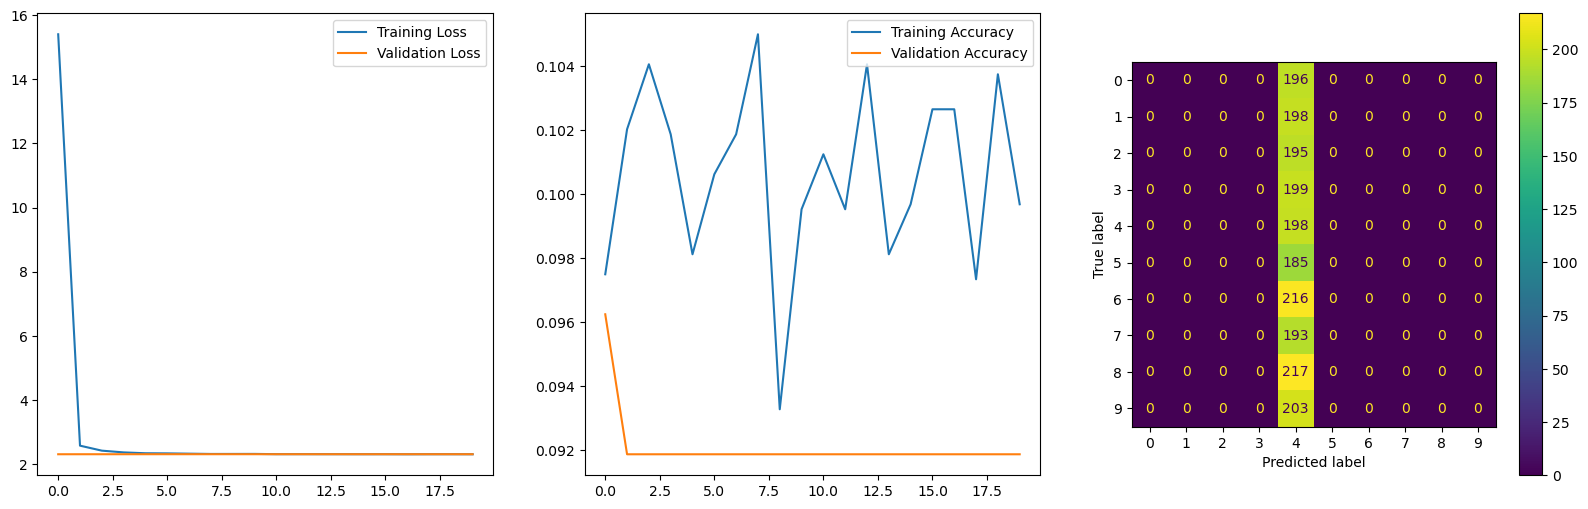

In [12]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.SpatialDropout2D(0.8)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.SpatialDropout2D(0.8)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.SpatialDropout2D(0.8)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.8)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

This still doesn't look good - but we do have some silly dropout rates going on. A good rule of thumb is to use around 0.2-0.3 for convolution layers, and 0.5 for dense layers. 

It's also important to note that using dropout will generally slow training time, as you always have part of the network disconnected.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


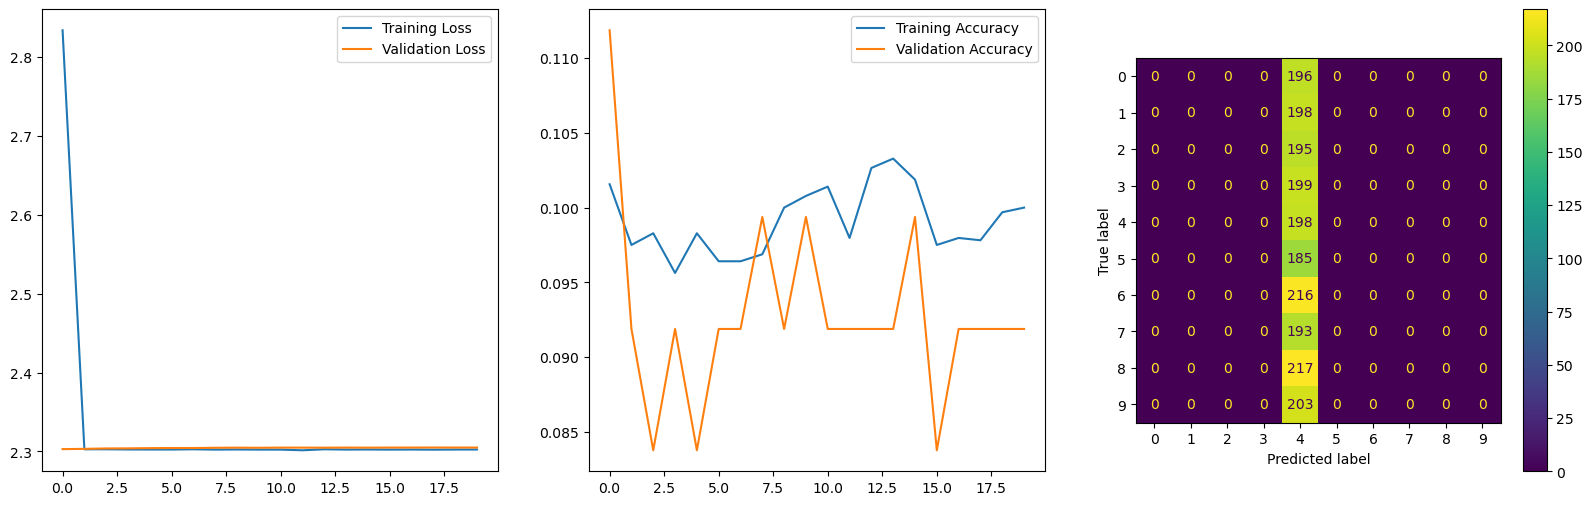

In [13]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

The above is working better, and we can see that we're running much longer until we overfit.

Aside from using dropout in this way, there are also some fascinating applications of dropout for estimating uncertainty (see and https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html and https://medium.com/@ahmdtaha/dropout-as-a-bayesian-approximation-representing-model-uncertainty-in-deep-learning-7a2e49e64a15). 

## Batch Normalisation (BatchNorm)

The other weapon we have for overfitting is batch normalisation. A batch normalisation layer normalises the activations at a point in the network. In this case, for a batch of data:
* We calculate the mean and standard deviations of the activations
* We normalise each sample in the batch by subtracting the mean and dividing by the standard deviation, such that our batch now has 0 mean and unit std.dev
* We scale by some learned mean and std.dev such that the batch has a known mean and std.dev

The main idea is to get the data back into a "shape" that we expect, which makes it easier to learn. If we consider a layer in the middle of the network, it's input is the output of the previous layer, which is impacted by all the earlier layers in the network. As such, any change in model parameters earlier in the network will impact what the activations look like in our middle layer. By using batch norm, we now at least know that our values here will have a particular mean and standard deviation, so it makes it a bit easier for that layer to learn.

A really good overview of BatchNorm is available on youtube here for those that are interested:
* https://www.youtube.com/watch?v=nUUqwaxLnWs
* https://www.youtube.com/watch?v=5qefnAek8OA

While you will find BatchNorm in most networks (more so than Dropout), there is still some debate as to exactly what it does and why. The zeroinit research (see here if you're interested https://openreview.net/forum?id=H1gsz30cKX) has some interesting insights regarding what's going on, and there are a number of other related papers exploring similar issues.

To add to the debate, it is not entirely settled whether BatchNorm should be before or after the activation (ReLu). If you poke around forums and github pages, you'll find lots of discussion on this. For science, we'll evaluate them both.

### BatchNorm, then Activation

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   


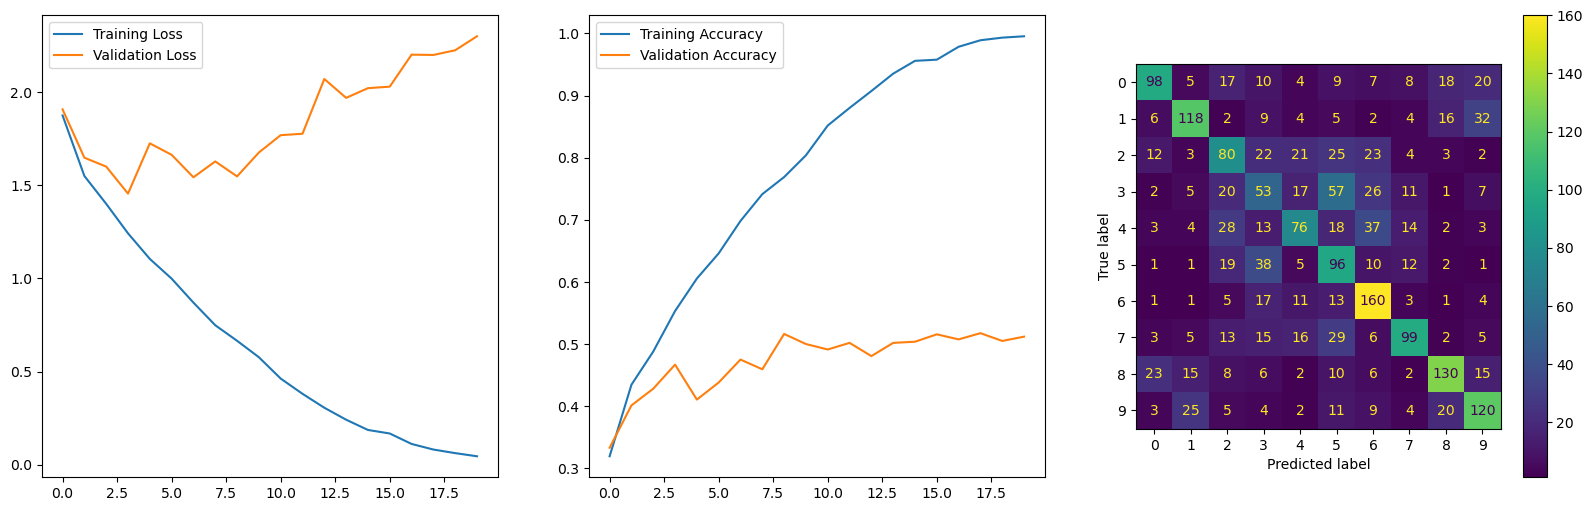

In [14]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(inputs)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.relu)(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation=None)(x)
x = layers.Activation(activations.relu)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

### Activation, then BatchNorm

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


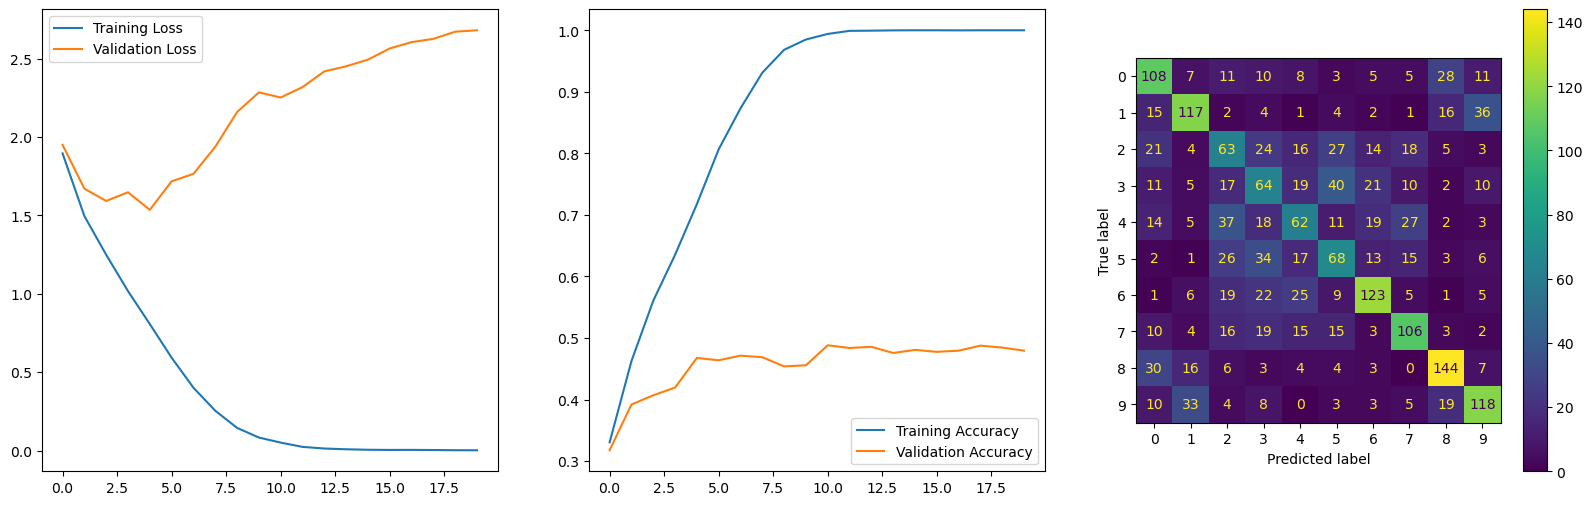

In [15]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(inputs)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.relu)(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation=None)(x)
x = layers.Activation(activations.relu)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

And the results of science are:
* BatchNorm before ReLu is (slightly) better, though this could be noise too (there is random variation at play in DCNN training)
* Both overfit, but do better than no normalisation

So which one, BatchNorm before or after ReLu? The point of batchnorm is to provide a checkpoint where a layer's output is normalised such that it has a known mean and std.dev. If we do this before ReLu, we will have half the values below 0 after BatchNorm, and these will get nuked by the ReLu (i.e. set to 0). If we do this after the ReLu, we've already lost the negative values, so the mean and std.dev. that we compute perhaps aren't truly representitive of the data. 

BatchNorm before ReLu is the prefered order for this reason - it gives BatchNorm the chance to operate over the whole set of trianing data. Though in some cases the other will work better, and it does somewhat depend on the architecture being used. In some respects neither one is ideal, as:
* BatchNorm -> Relu means that ~50% of our activations are set to 0, slowing information flow
* Relu -> BatchNorm means that BatchNorm is no longer operating over the true representation of the data

This is where different activation functions that allow more information through can be useful. We've only considered a ReLu activation here which has a hard cutoff, anything below $0$ is "turned off". A LeaklyReLu, or an ELU, or a Swish, that allows a certain amount of the below zero activation to filter will yield different results and will allow more information to flow through the network.

## BatchNorm and Dropout Together

Can these two layer be used together? Yes, but dropout is less used in current architectures. In terms of placement. We have a similar sort of argument as we do with the activation. Placing dropout before BatchNorm means that our BatchNorm layer doesn't see all the data, and so estimates it's mean and std.dev off partial data; though if our dropout rate is low this won't be a huge issue.

For the sake of completeness, let's now put all the pieces together and see what we can end up with. We will:
* Include our same three BatchNorms from before, keeping them before the activation
* Add some spatial dropout in
* Add some weight regularisation to the dense layer

I'm also going to swap out the activations for swish activations, which will let slightly more information flow through. The network will also train for much longer. To avoid overfitting, we'll also add an early stopping callback.

One thing I'm not doing is adding more filters, or more computational layers, we'll see how far we can push it with the limited resources we have.

E0000 00:00:1738041048.387165  562617 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/simple_cifar_cnn_1/spatial_dropout2d_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   


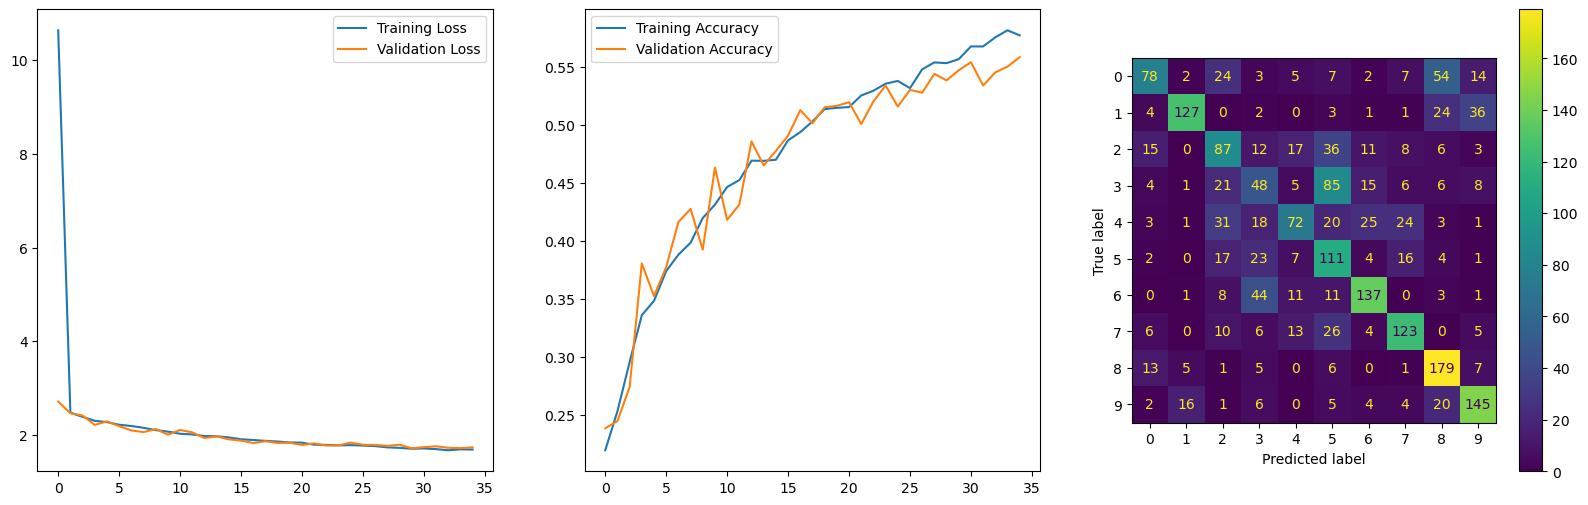

In [16]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(inputs)
x = layers.Activation(activations.swish)(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.swish)(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.swish)(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.swish)(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.Activation(activations.swish)(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.swish)(x)
x = layers.SpatialDropout2D(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation=None, kernel_regularizer='l1')(x)
x = layers.Activation(activations.swish)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='simple_cifar_cnn')

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=100,
                        validation_split=0.2, verbose=False, 
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])
plot_training(history, model_cnn, x_test, y_test)

In the end, we're doing better, but we're still a long way from 100%. Keep in mind that we never really increased the complexity of this network, and we're only using 20% of the data (and of that, we're holding out some for validation and testing). All in all, we're not set up to achieve amazing results on this data with those constraints, instead we're set up to overfit which we've managed to curb somewhat with the above tweaks.